In [182]:
import numpy as np
import pandas as pd
import imputation as imp
import forecasting as fc
import matplotlib.pyplot as plt
import time
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from codecarbon import EmissionsTracker
from eco2ai import Tracker

In [183]:
df = pd.read_csv("datasets/genome/electricity_cleaned.csv", index_col='timestamp', parse_dates=True)
df = df.select_dtypes(include="number")
metadata = pd.read_csv("datasets/genome/metadata.csv")

[codecarbon INFO @ 20:11:43] Energy consumed for RAM : 0.000043 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:11:43] Energy consumed for RAM : 0.000164 kWh. RAM Power : 10.0 W


In [184]:
site_ids = metadata["site_id"].unique()
print(site_ids)

target_site = "Mouse"
cols = [col for col in df.columns if col.startswith(target_site)]
df = df[cols]

['Panther' 'Robin' 'Fox' 'Rat' 'Bear' 'Lamb' 'Peacock' 'Moose' 'Gator'
 'Bull' 'Bobcat' 'Crow' 'Shrew' 'Swan' 'Wolf' 'Hog' 'Eagle' 'Cockatoo'
 'Mouse']


In [ ]:
imputation_methods = {
    "LOCF": imp.locf,
    "NOCB": imp.nocb,
    "Linear Interpolation": imp.linear_interpolation,
    "Linear Regression": imp.linear_regression,
    "LightGBM": imp.lightgbm,
}
rng = np.random.default_rng(seed=42)
target = rng.choice(cols)

imputed = {}
performance = {}
df_masked, samples = imp.create_mcar_data(df, missing=0.2, seed=42)

for n, f in imputation_methods.items():
    cc_tracker = EmissionsTracker(
        project_name=n,
        output_dir="performance",
        output_file=f"genome_{target_site}_codecarbon.csv",
    )
    eco_tracker = Tracker(project_name=n, file_name=f"eco2ai_{target_site}.csv")

    # Start time and emission trackers
    cc_tracker.start()
    eco_tracker.start()
    start_time = time.time()

    df_imputed = f(df_masked.copy())

    # Stop trackers
    end_time = time.time()
    emissions = cc_tracker.stop()
    eco_tracker.stop()

    # Store imputed data in dictionary
    imputed[n] = df_imputed

    # Get error metrics only for the masked values
    i = df.columns.get_loc(target)
    mask = samples[:, i]
    y_true = df.values[:, i][mask]
    y_pred = df_imputed.values[:, i][mask]

    valid = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[valid]
    y_pred = y_pred[valid]

    # Compute error
    mae = mean_absolute_error(y_true, y_pred)
    nrmse = root_mean_squared_error(y_true, y_pred) / (np.max(y_true) - np.min(y_true))

    performance[n] = {
        "MAE": mae,
        "NRMSE": nrmse,
    }

[codecarbon WARNING @ 20:11:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:11:43] [setup] RAM Tracking...
[codecarbon INFO @ 20:11:43] [setup] CPU Tracking...
[codecarbon INFO @ 20:11:44] Delta energy consumed for CPU with cpu_load : 0.000025 kWh, power : 5.7088 W
[codecarbon INFO @ 20:11:44] Energy consumed for All CPU : 0.000025 kWh
[codecarbon INFO @ 20:11:44] 0.000068 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:11:44] Delta energy consumed for CPU with cpu_load : 0.000023 kWh, power : 5.61 W
[codecarbon INFO @ 20:11:44] Energy consumed for All CPU : 0.000095 kWh
[codecarbon INFO @ 20:11:44] 0.000259 kWh of electricity used since the beginning.
[codecarbon WARNING @ 20:11:44] We saw that you have a AMD Ryzen 5 7530U with Radeon Graphics but we don't know it. Please contact us.
[codecarbon WARNING @ 20:11:44] We will use the default power consumption of 4 W per thread for your 12 CPU, so 48W.
[codecarbon WARNING 

[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 4853, number of used features: 6
[LightGBM] [Info] Start training from score 17.661504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 12738, number of used features: 6
[LightGBM] [Info] Start training from score 531.330680
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 12724, number of used features: 6
[LightGBM] [Info] Start training from score 45.766109
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 12690, number of used features: 6
[LightGBM] [Info] Start training from score 783.261217
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 12561, number of used features: 6
[LightGB

[codecarbon INFO @ 20:12:21] Energy consumed for RAM : 0.000005 kWh. RAM Power : 10.0 W


[LightGBM] [Info] Total Bins 722
[LightGBM] [Info] Number of data points in the train set: 12812, number of used features: 6
[LightGBM] [Info] Start training from score 384.727312
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 5829, number of used features: 6
[LightGBM] [Info] Start training from score 437.922900


[codecarbon INFO @ 20:12:22] Delta energy consumed for CPU with cpu_load : 0.000006 kWh, power : 11.136000000000001 W
[codecarbon INFO @ 20:12:22] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 20:12:22] 0.000011 kWh of electricity used since the beginning.
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attributes_dataframe.loc[row_index] = attributes_array
/home/milou/Documents/afstudeerproject/.venv/lib/python3.12/site-packages/eco2ai/emission_track.py:515: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0831952095031738' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
 

[codecarbon INFO @ 20:12:34] Energy consumed for RAM : 0.002257 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:35] Delta energy consumed for CPU with cpu_load : 0.000030 kWh, power : 7.422000000000001 W
[codecarbon INFO @ 20:12:35] Energy consumed for All CPU : 0.002260 kWh
[codecarbon INFO @ 20:12:35] 0.004517 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:35] 0.000010 g.CO2eq/s mean an estimation of 0.3294926626745986 kg.CO2eq/year
[codecarbon INFO @ 20:12:39] Energy consumed for RAM : 0.002137 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:40] Delta energy consumed for CPU with cpu_load : 0.000025 kWh, power : 6.291 W
[codecarbon INFO @ 20:12:40] Energy consumed for All CPU : 0.002177 kWh
[codecarbon INFO @ 20:12:40] 0.004314 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:58] Energy consumed for RAM : 0.000244 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:59] Delta energy consumed for CPU with cpu_load : 0.000020 kWh, power : 4.84

[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 6
[LightGBM] [Info] Start training from score 12.947260
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 6
[LightGBM] [Info] Start training from score 10.988380


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

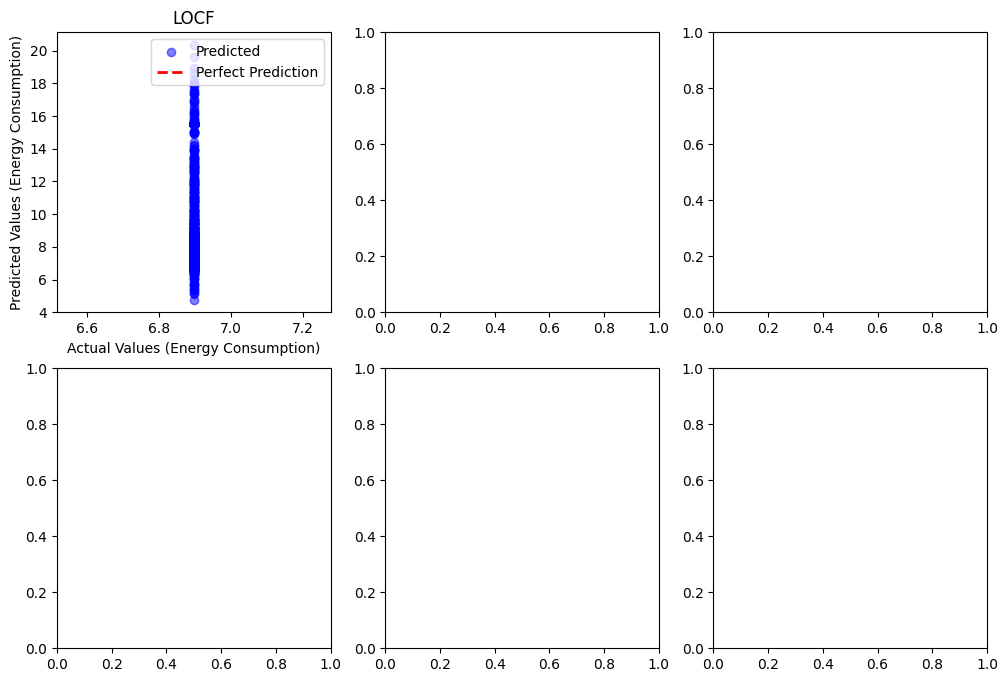

[codecarbon INFO @ 20:12:24] Energy consumed for RAM : 0.002097 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:25] Delta energy consumed for CPU with cpu_load : 0.000034 kWh, power : 8.34 W
[codecarbon INFO @ 20:12:25] Energy consumed for All CPU : 0.002152 kWh
[codecarbon INFO @ 20:12:25] 0.004249 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:25] Energy consumed for RAM : 0.006848 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:25] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 7.953000000000002 W
[codecarbon INFO @ 20:12:25] Energy consumed for All CPU : 0.006817 kWh
[codecarbon INFO @ 20:12:25] 0.013665 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:12:28] Energy consumed for RAM : 0.000164 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:28] Energy consumed for RAM : 0.000285 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:12:29] Delta energy consumed for CPU with cpu_load : 0.000031 kWh, power : 7.734000000000001 W


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()
forecasting = {}

features = [col for col in df.columns if col != target]

for i, (name, df_imputed) in enumerate(imputed.items()):
    X = df_imputed[features]
    y = df_imputed[target]

    X_train, X_test, y_train, y_test = fc.split_data(X, y, train_size=0.8)

    model = LGBMRegressor(force_col_wise=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    valid = (~np.isnan(y_test)) & (~np.isnan(y_pred))
    forecasting[name] = mean_absolute_error(y_test[valid], y_pred[valid])

    axs[i].scatter(y_test, y_pred, alpha=0.5, label="Predicted", color="b")
    axs[i].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "r--",
        lw=2,
        label="Perfect Prediction",
    )
    axs[i].set_xlabel("Actual Values (Energy Consumption)")
    axs[i].set_ylabel("Predicted Values (Energy Consumption)")
    axs[i].set_title(f"{name}")
    axs[i].legend()


axs[-1].axis("off")
fig.suptitle(f"{target_site} - {target}: Actual vs Predicted Values")
plt.tight_layout()
plt.savefig(f"performance/figures/genome/forecasting_{target_site}.png")
plt.show()

In [ ]:
df_performance = pd.DataFrame.from_dict(performance, orient="index")
print(df_performance)
df_forecasting = pd.DataFrame.from_dict(forecasting, orient="index")
print(df_forecasting)

                           MAE     NRMSE
LOCF                  5.834937  0.077228
NOCB                  5.867541  0.077959
Linear Interpolation  4.047215  0.053164
Linear Regression     6.371866  0.080177
LightGBM              5.034916  0.064714
                             0
LOCF                  6.470779
NOCB                  6.491089
Linear Interpolation  5.971105
Linear Regression     5.428234
LightGBM              5.295598


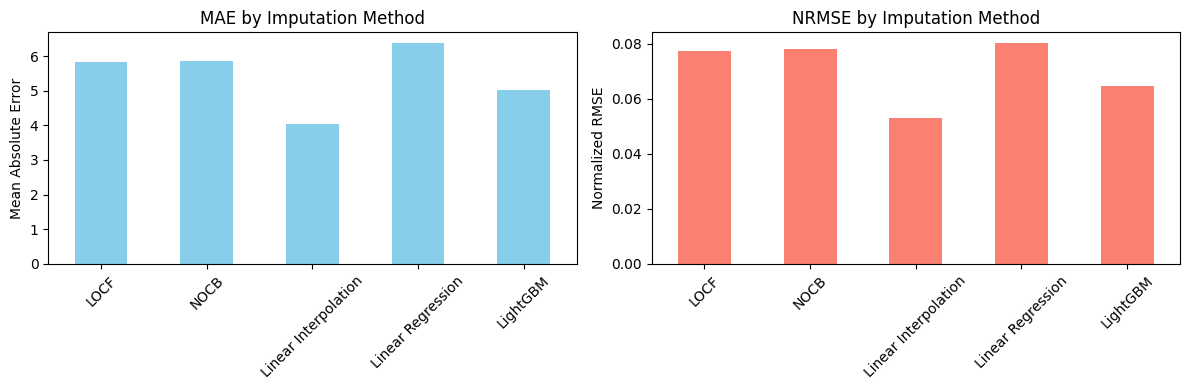

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df_performance["MAE"].plot(kind="bar", ax=axs[0], color="skyblue")
axs[0].set_title("MAE by Imputation Method")
axs[0].set_ylabel("Mean Absolute Error")
axs[0].set_xticklabels(df_performance.index, rotation=45)

df_performance["NRMSE"].plot(kind="bar", ax=axs[1], color="salmon")
axs[1].set_title("NRMSE by Imputation Method")
axs[1].set_ylabel("Normalized RMSE")
axs[1].set_xticklabels(df_performance.index, rotation=45)

plt.tight_layout()
plt.savefig(f"performance/figures/genome/error_{target_site}.png")
plt.show()

                       duration     emissions  energy_consumed
project_name                                                  
LOCF                   2.154975  1.817486e-06         0.000007
NOCB                   2.151994  1.611329e-08         0.000007
Linear Interpolation   2.240382  1.910637e-06         0.000007
Linear Regression     26.064107  9.019177e-07         0.000379
LightGBM              47.999741  1.056270e-06         0.000444
LOCF                   2.162965  1.622299e-08         0.000007
NOCB                   2.159226  1.822153e-06         0.000007
Linear Interpolation   2.244107  1.701695e-08         0.000007
Linear Regression     25.325755  9.595132e-05         0.000359
LightGBM              53.366638  1.378619e-04         0.000515


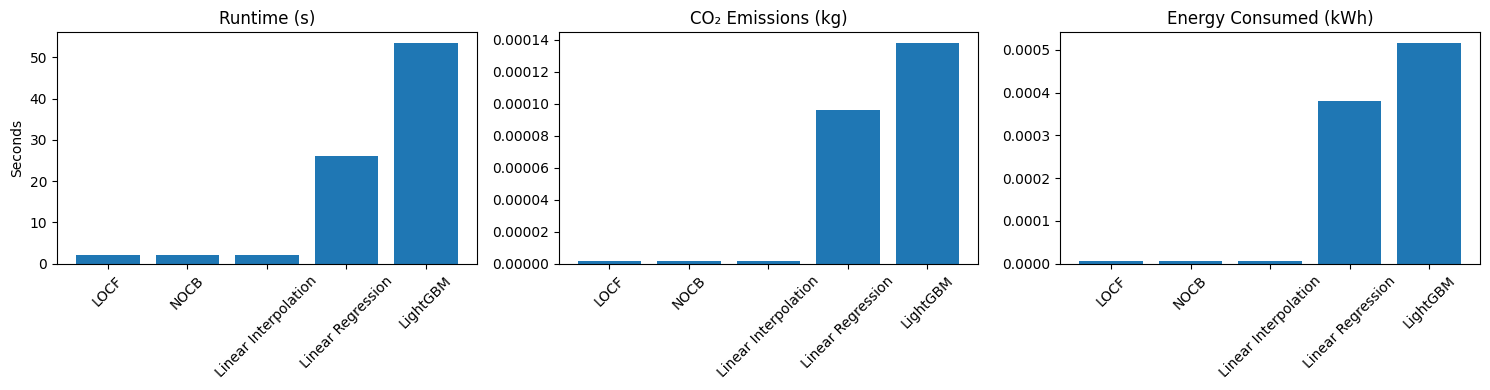

In [ ]:
df_emission = pd.read_csv(f"performance/genome_{target_site}_codecarbon.csv")
df_emission_cleaned = df_emission[["project_name", "duration", "emissions", "energy_consumed"]]
df_emission_cleaned = df_emission_cleaned.set_index("project_name")

print(df_emission_cleaned)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar(df_emission_cleaned.index, df_emission_cleaned["duration"])
axs[0].set_title("Runtime (s)")
axs[0].set_ylabel("Seconds")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(df_emission_cleaned.index, df_emission_cleaned["emissions"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(df_emission_cleaned.index, df_emission_cleaned["energy_consumed"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"performance/figures/genome/cc_emissions_{target_site}.png")
plt.show()

[codecarbon INFO @ 20:04:09] Energy consumed for RAM : 0.000768 kWh. RAM Power : 10.0 W


                      duration(s)  CO2_emissions(kg)  power_consumption(kWh)
project_name                                                                
LOCF                     0.781174       2.804109e-08            7.114916e-08
NOCB                     0.784484       3.535228e-08            8.969997e-08
Linear Interpolation     0.875056       3.209394e-08            8.143252e-08
Linear Regression       24.693196       3.317739e-05            8.418157e-05
LightGBM                46.631191       3.493929e-05            8.865208e-05
LOCF                     0.786822       2.778234e-08            7.049263e-08
NOCB                     0.788884       2.830775e-08            7.182576e-08
Linear Interpolation     0.874198       3.213065e-08            8.152566e-08
Linear Regression       23.956328       3.107039e-05            7.883544e-05
LightGBM                51.992043       3.716935e-05            9.431045e-05


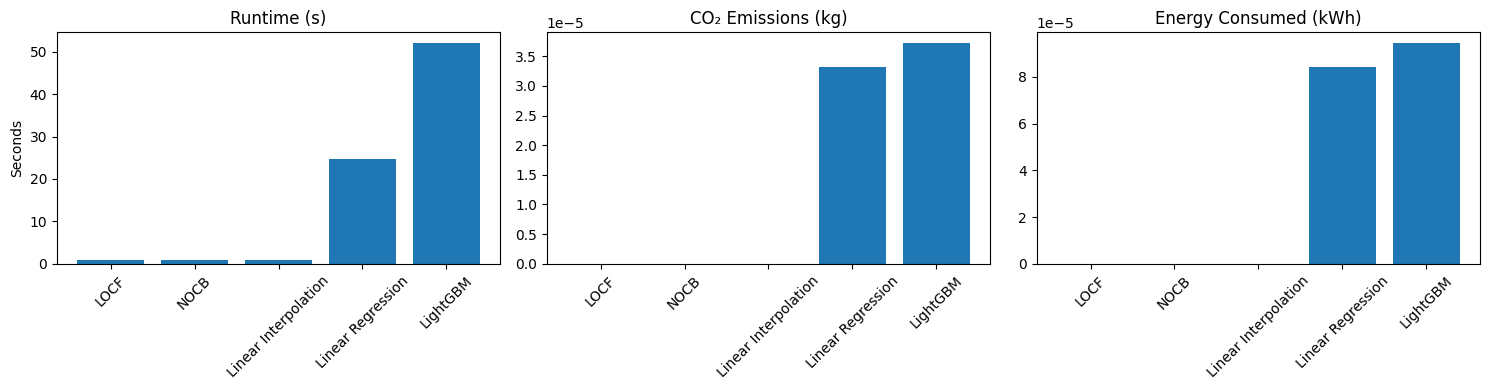

[codecarbon INFO @ 20:04:10] Delta energy consumed for CPU with cpu_load : 0.000084 kWh, power : 20.790000000000003 W
[codecarbon INFO @ 20:04:10] Energy consumed for All CPU : 0.001456 kWh
[codecarbon INFO @ 20:04:10] 0.002224 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:10] Energy consumed for RAM : 0.005519 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:04:10] Delta energy consumed for CPU with cpu_load : 0.000079 kWh, power : 19.554000000000002 W
[codecarbon INFO @ 20:04:10] Energy consumed for All CPU : 0.006117 kWh
[codecarbon INFO @ 20:04:10] 0.011636 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:04:18] Energy consumed for RAM : 0.005841 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:04:19] Delta energy consumed for CPU with cpu_load : 0.000037 kWh, power : 9.201 W
[codecarbon INFO @ 20:04:19] Energy consumed for All CPU : 0.006239 kWh
[codecarbon INFO @ 20:04:19] 0.012081 kWh of electricity used since the beginning.
[codecarbon INFO @

In [ ]:
# Plot eco2ai performance
df_emission = pd.read_csv(f"eco2ai_{target_site}.csv")
df_emission_cleaned = df_emission[["project_name", "duration(s)", "CO2_emissions(kg)", "power_consumption(kWh)"]]
df_emission_cleaned = df_emission_cleaned.set_index("project_name")

print(df_emission_cleaned)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].bar(df_emission_cleaned.index, df_emission_cleaned["duration(s)"])
axs[0].set_title("Runtime (s)")
axs[0].set_ylabel("Seconds")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(df_emission_cleaned.index, df_emission_cleaned["CO2_emissions(kg)"])
axs[1].set_title("CO₂ Emissions (kg)")
axs[1].tick_params(axis='x', rotation=45)

axs[2].bar(df_emission_cleaned.index, df_emission_cleaned["power_consumption(kWh)"])
axs[2].set_title("Energy Consumed (kWh)")
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"performance/figures/genome/eco_emissions_{target_site}.png")
plt.show()